Please complete the `NotImplemented` parts of the code cells and write your answers in the markdown cells designated for your response to any questions asked. The tag `# AUTOGRADED` (all caps, with a space after `#`) should be at the beginning of each autograded code cell, so make sure that you do not change that. You are also not allowed to import any new package other than the ones already imported. Doing so will prevent the autograder from grading your code.

For the code submission, run the last cell in the notebook to create the submission zip file. If you are working in Colab, make sure to download and then upload a copy of the completed notebook itself to its working directory to be included in the zip file. Finally, submit the zip file to Gradescope.

After you finish the assignment and fill in your code and response where needed (all cells should have been run), save the notebook as a PDF using the `jupyter nbconvert --to pdf HW4.ipynb` command (via a notebook code cell or the command line directly) and submit the PDF to Gradescope under the PDF submission item. If you cannot get this to work locally, you can upload the notebook to Google Colab and create the PDF there. You can find the notebook containing the instruction for this on Canvas.

If you are running the notebook locally, make sure you have created a virtual environment (using `conda` for example) and have the proper packages installed. We are working with `python=3.10` and `torch>=2`.

Files to be included in submission:

- `HW4.ipynb`
- `model_config.yaml`
- `train_config.yaml`
- `experiments.xlsx`

# Implement and Train a Convolutional ResNet on CIFAR-10

In [21]:
"""
DO NOT CHANGE THIS CELL OR ADD ANY IMPORTS ANYWHERE IN THE NOTEBOOK!
"""

# utilities
import os
from typing import Sequence

# for interactive plotting
try:
    from google.colab import drive
    drive.mount("/content/drive")
    # save a copy of the notebook to the drive
except ImportError:
    print("Not in Colab")
os.system('pip install openpyxl -qq')

import pandas as pd
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# provided code you can or should use:

import sys
sys.path.append('/content/drive/MyDrive/24788/HW4')
from HW4_utils import save_yaml, load_yaml, zip_files, Tracker, train

import torch
from torch import nn
import torch.nn.functional as F

from torchvision import datasets
from torchvision.transforms import v2

if torch.cuda.is_available():
    Device = 'cuda'
elif torch.backends.mps.is_available():
    Device = 'mps'
else:
    Device = 'cpu'

print(f'Device is {Device}')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Device is cuda


## Implement a ResNet model (50)

First, you have to implement a Convolutional [ResNet](https://arxiv.org/pdf/1512.03385). You can add additional code cells and test your model with random inputs of the correct shape, dtype, and device, to make sure it runs without any errors before using it in the actual training. You can also print the shape through the model to check if it processes the data as intended.

Below you can find a simple illustration of a ResNet Block that you have to implement. Putting aside the batch dimension (number of samples in a batch), the input is of shape `(C, H, W)` where `C, H, W` stand for the number of input channels, height, and width respectively. Each block has an expansion factor of `e`, meaning that the number of channels will be multiplied by `e` after `conv1`, and stay the same number throughout the rest of the block. The spatial dimensions will be divided by `e` by the strided convolution of `conv1`. If `e == 1`, the shape of the tensor is the same throughout the block, and the shortcut (if the block is residual) is just the identity (`nn.Identity()`). However, if `e > 1`, the input and the output are not the same shape and cannot be added together. To get around this, the shortcut has to apply a convolutional layer of the right configuration to change the shape of the input tensor (do not forget batchnorm if we are using it). The batchnorm layers (`bn`) will be optional, and whether to use batchnorm is determined by the boolean flag `batchnorm` of the constructor of the block. The shortcut connection is also optional, determined by the boolean flag `residual` passed to the constructor.

After you implement the ResNet Block in `Block`, you will use it to implement the `Model`. The Model starts with an input layer called `layer0` (a convolutional layer, an optional batchnorm, and an activation) that does not change the spatial shape and creates `base_channels` feature maps from the input. Then there are several residual blocks, and finally a fully connected layer at the end. The output of the last block has to go through a global average pooling layer before the fully connected layer. Think about which of the [pooling functions](https://pytorch.org/docs/stable/nn.functional.html#pooling-functions) you should use and how. The global average pooling layer should thake the average of all pixels (channelwise), regardless of the input shape. The number of blocks is decided by the length of the `expands` arguments, which is a `list` containing the expansion factor of each block.

You should use `kernel_size = 3` for all `nn.Conv2d` modules. However, you have to decide the correct value for `stride` and `padding` to keep the shapes as intended.

Is there any other module or activation needed after the final linear layer? If so, include that as well. Keep in mind that this is a multi-class classification task and the output of the model is going to be passed to [`nn.CrossEntropyLoss()`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html), so read its documentation to see what the model's output has to be.

Your grade depends on your implementation being well written based on the constructor arguments. You will lose points if you call a module that does not exist, or define modules that are not needed and unnecessarily take extra memory. For example, if `batchnorm` is `False`, the block and the model should not have any batchnorm modules. If `expand` is `1`, the residual connection should not change the input. Otherwise, the shortcut has to consist of a convolution, and batchnorm (only if `batchnorm` is `True`) and an activation. If `residual` is `False`, there should not be any shortcut connection. For nonparameteric transformations like the activation, use calls from `torch` or `torch.nn.functional` (imported as `F`) directly in the `forward` method.

After you are done, clean your code from print statements and parts that were there only for debugging.

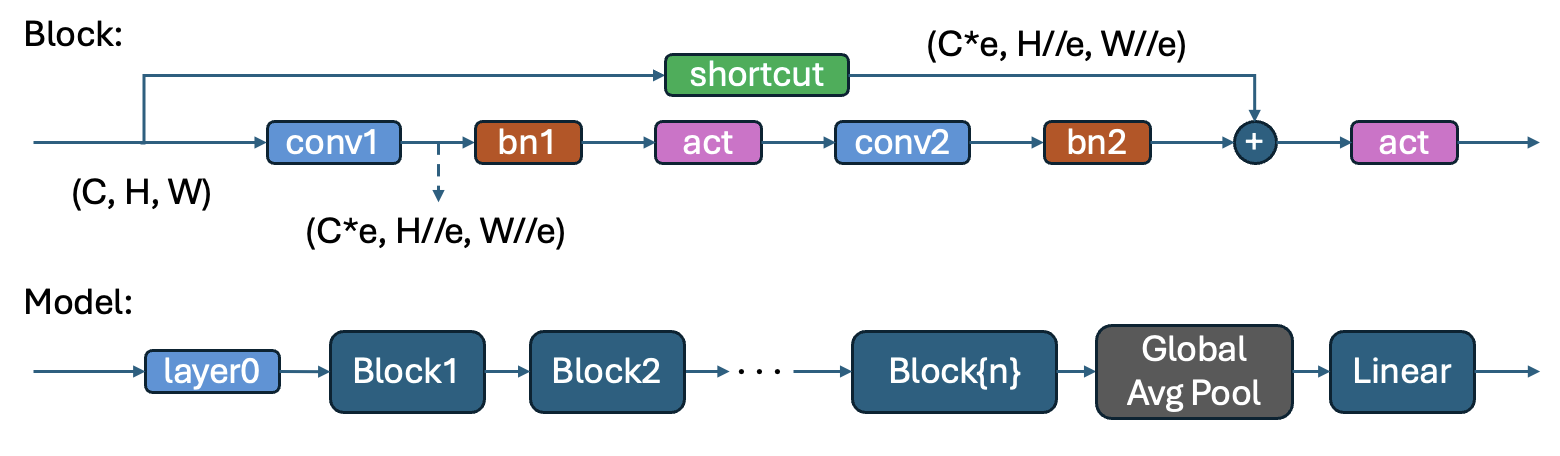

In [9]:
class Block(nn.Module):

    def __init__(
            self,
            in_channels: int,
            expand: int = 1,
            activation: str = 'relu',
            batchnorm: bool = False,
            residual: bool = False,
            ):
        super().__init__()

        self.act = F.__getattribute__(activation)

        out_channels = in_channels * expand

        self.conv1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=3,
            stride=expand,
            padding=1,
        )
        if batchnorm:
            self.bn1 = nn.BatchNorm2d(out_channels)
        else:
            self.bn1 = nn.Identity()

        self.conv2 = nn.Conv2d(
            in_channels=out_channels,
            out_channels=out_channels,
            kernel_size=3,
            stride=1,
            padding=1,
        )
        if batchnorm:
            self.bn2 = nn.BatchNorm2d(out_channels)
        else:
            self.bn2 = nn.Identity()

        self.residual = residual
        if self.residual:
            if expand == 1:

                self.short = nn.Identity()
            else:

                if batchnorm:
                    self.short = nn.Sequential(
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=out_channels,
                            kernel_size=1,
                            stride=expand
                        ),
                        nn.BatchNorm2d(out_channels)
                    )
                else:
                    self.short = nn.Conv2d(
                        in_channels=in_channels,
                        out_channels=out_channels,
                        kernel_size=1,
                        stride=expand
                    )
        else:

            self.short = None

    def forward(
            self,
            x: torch.FloatTensor, # (B, C, H, W)
            ) -> torch.FloatTensor: # (B, C*e, H//e, W//e)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.act(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.residual:
            out = out + self.short(x)

        out = self.act(out)
        return out

class Model(nn.Module):

    def __init__(
            self,
            base_channels: int,
            expands: Sequence[int],
            activation: str = 'relu',
            batchnorm: bool = False,
            residual: bool = False,
            ):
        super().__init__()

        self.act = F.__getattribute__(activation)

        self.layer0_conv = nn.Conv2d(
            in_channels=3,
            out_channels=base_channels,
            kernel_size=3,
            stride=1,
            padding=1
        )
        if batchnorm:
            self.layer0_bn = nn.BatchNorm2d(base_channels)
        else:
            self.layer0_bn = nn.Identity()

        blocks = []
        in_channels = base_channels
        for e in expands:
            blocks.append(
                Block(
                    in_channels=in_channels,
                    expand=e,
                    activation=activation,
                    batchnorm=batchnorm,
                    residual=residual
                )
            )
            in_channels = in_channels * e
        self.blocks = nn.Sequential(*blocks)

        self.cls = nn.Linear(in_channels, 10)


    def forward(
            self,
            x: torch.FloatTensor,
            ) -> torch.FloatTensor:

        x = self.layer0_conv(x)
        x = self.layer0_bn(x)
        x = self.act(x)

        x = self.blocks(x)


        x = F.adaptive_avg_pool2d(x, output_size=1)

        x = x.view(x.size(0), -1)
        x = self.cls(x)
        return x

## Data Augmentation (5)

Apply at least three types of data augmentation.
You can change the directory that the data is stored at. It can be a folder in your local machine or Google drive if you are using Colab.

In [10]:
data_path = 'data'

train_data = datasets.CIFAR10(
    root = data_path,
    train = True,
    download = True,
    transform = v2.Compose([
        v2.ToImage(),
        v2.RandomHorizontalFlip(p=0.5),
        v2.RandomRotation(degrees=15),
        v2.ColorJitter(brightness=0.2),
        v2.ToDtype(torch.float32, scale=True), # to [0, 1]
        v2.Lambda(lambda x: x-0.5), # to [-0.5, 0.5]
        ])
        )

test_data = datasets.CIFAR10(
    root = data_path,
    train = False,
    download = True,
    transform = v2.Compose(
        [
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True), # to [0, 1]
        v2.Lambda(lambda x: x-0.5), # to [-0.5, 0.5]
        ])
        )

Files already downloaded and verified
Files already downloaded and verified


## Training and Hyperparameter Tuning (20)

Next, you are going to explore the model hyperparameters. Later, you are going to verify the effectiveness of batchnorm and shortcut connections. To perform a fair comparison, first find a good configuration for the base model with batchnorm and residual connection. Then, we will do an ablation study by training a version of your successful model without those components. You will form your conclusions based on the results you observe. If you get the best grade at your first try, you have great luck, but __you have to run at least 5 experiments__ with different configurations to get 5 points of this part. Try at least one model with `batchnorm = False` and one with `residual = False` and one with both `False`. The goal is to see the effect of these models. We suggest you find a successful model with both `True`, and perform an ablation study to see their effect by excluding them from the model.

In this assignment, we have to keep track of the previous experiments to compare the results later in a table. For that purpose, we will save the information about each experiment in a folder to access it later. The code is set up so that it counts the numbder of folders, and names them as their index in the order that they were conducted. The first experiment will create the first folder called `00`, the next one will be `01`, and so on.

To keep track of your past experiments more efficiently, you will have to use `pandas` to create a dataframe that collects the information about your past experiments. 15 points of your grade depend on your dataframe. The dataframe you create should be displayed in the notebook in your submission. The rows should correspond to different experiments, and different columns are different hyperparameters (including both the model and the training) and the metrics (loss and accuracy on train and test dataset).

15 points of your grade depend on the best test accuracy you achieve:

$acc \geq 90\% \rightarrow$ 25 points (10 bonus)

$85\% \leq acc < 90\% \rightarrow$ 20 points (5 bonus)

$80\% \leq acc < 85\% \rightarrow$ 15 points

$75\% \leq acc < 80\% \rightarrow$ 10 points

$70\% \leq acc < 75\% \rightarrow$ 5 points

$acc < 70\% \rightarrow$ 0 points

In [11]:
"""
Choose the folder to save model checkpoints and results.
In Colab, this is a folder in your drive (somewhere in /content/drive/MyDrive/...) where you have your course content
"""
results_dir = '/content/drive/MyDrive/24788/HW4/results'
os.makedirs(results_dir, exist_ok=True)

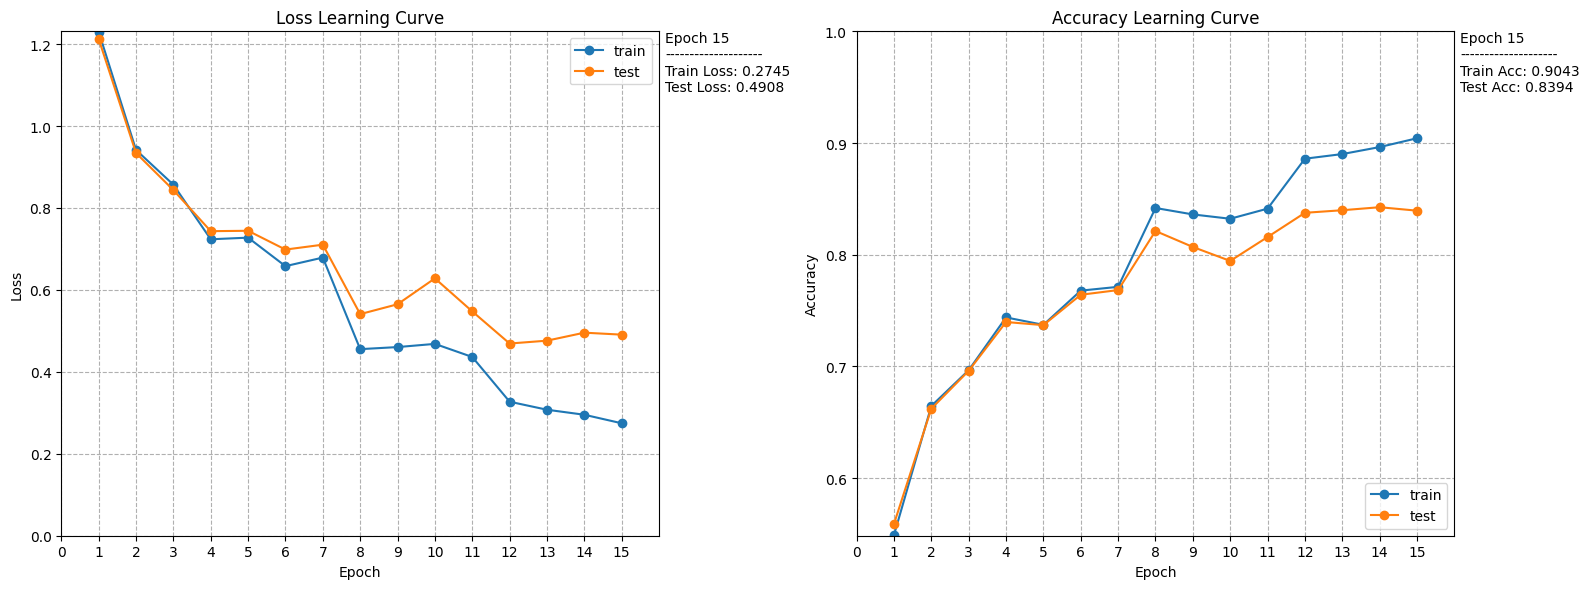

epochs: 100%|██████████| 15/15 [38:17<00:00, 153.19s/epoch]


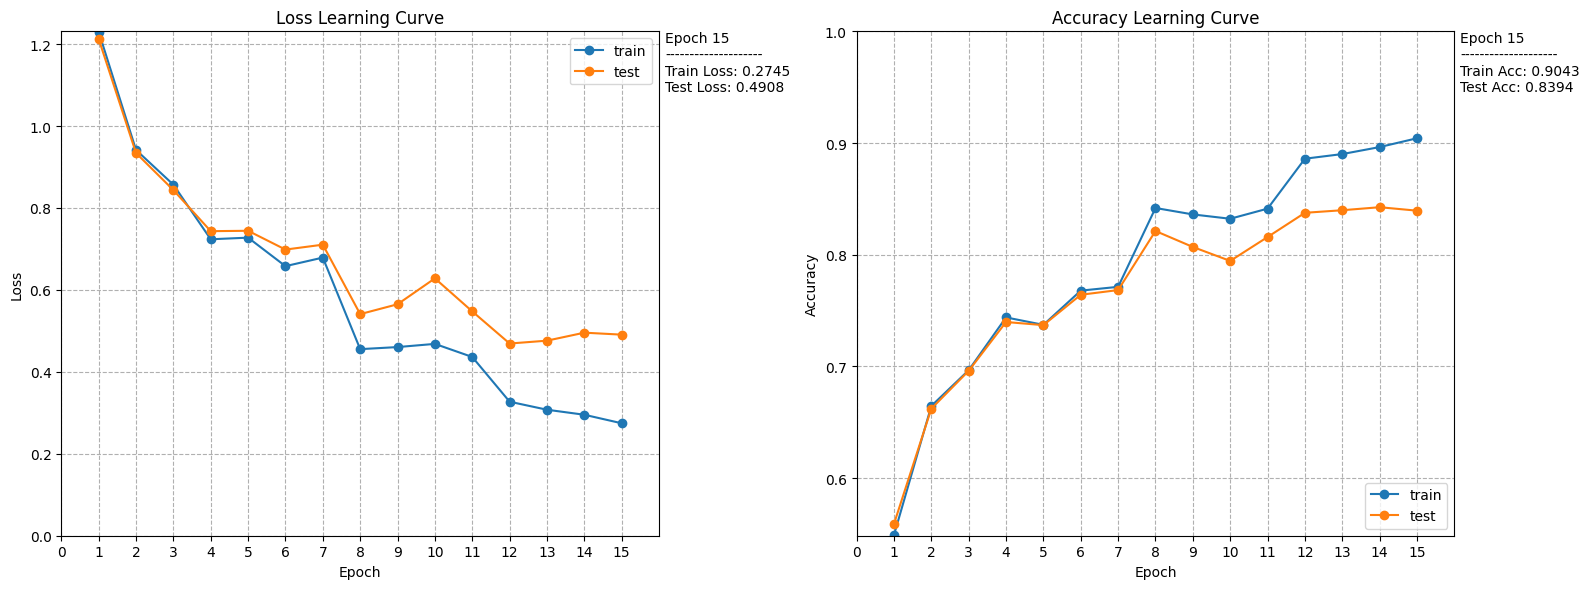

In [15]:
"""
Find a good model config and train config.

You can run this cell as many times as you want.
Each time, a new experiment will run and the information will be saved in the save_path folder.
"""

model_config = dict(
    base_channels = 128,
    expands = [1,2,2,2],
    activation = 'relu',
    batchnorm = True,
    residual = True,
    )

train_config = dict(
    optim_name = 'Adam',
    optim_config = {
        'lr': 0.001,
        'weight_decay': 1e-4
    },
    lr_scheduler_name = 'OneCycleLR',
    lr_scheduler_config = {
        'max_lr': 0.005,
        'total_steps': 20 * len(train_data)//256
    },
    n_epochs = 15,
    batch_size = 512,
)



n_experiments = len(os.listdir(results_dir))
name = f'{n_experiments:02d}'
save_path = f'{results_dir}/{name}'
os.makedirs(save_path, exist_ok=False) # Not Overwrite

save_yaml(model_config, f'{save_path}/model_config.yaml')
save_yaml(train_config, f'{save_path}/train_config.yaml')

train(
    save_path = save_path,
    model = Model(**model_config).to(Device),
    train_data = train_data,
    test_data = test_data,
    loss_fn = nn.CrossEntropyLoss(),
    device = Device,
    train_pbar = False,
    val_pbar = False,
    plot_freq = 1, # plot the curve every how many epochs
    save_freq = 1, # save the model state dict every how many epochs
    **train_config,
    )


## Create a table from the experiments to summarize the results (15)

Create a `pandas` dataframe from the saved information about the experiments.

The rows should be the different experiments, with the index being called `name`, which is the name of the experiment folder as a two digit format.

The columns should be the hyperparameters for the model and training, with the same name as the keys in the `model_config` and `train_config` dictionaries.

The columns should also include the following:

- `train_loss`: the final training loss

- `test_loss`: the final test loss

- `train_acc`: the final training accuracy

- `test_acc`: the final test accuracy

You can retrieve these values using the Tracker's `load_results` method, and access them through the tracker.

After you are done, save the dataframe as an excel file and display it in the notebook.

For the PDF submission, assign the pages corresponding to the output of the following cell for the table, and the cell output for the results, to be graded. If you do not assign the correct pages of the PDF, you will be penalized.

In [22]:
table = pd.DataFrame()

results_dir = '/content/drive/MyDrive/24788/HW4/results'
experiment_dirs = sorted(
    [d for d in os.listdir(results_dir)
     if os.path.isdir(os.path.join(results_dir, d)) and d.isdigit()]
)

for exp_name in experiment_dirs:
    exp_path = os.path.join(results_dir, exp_name)
    try:
        model_cfg = load_yaml(os.path.join(exp_path, 'model_config.yaml'))
        train_cfg = load_yaml(os.path.join(exp_path, 'train_config.yaml'))

        tracker = Tracker(n_epochs=1)
        tracker.load_results(os.path.join(exp_path, 'results.pkl'))

        record = {
            **model_cfg,
            **train_cfg,
            'train_loss': tracker.train_losses[-1],
            'test_loss': tracker.test_losses[-1],
            'train_acc': tracker.train_accs[-1],
            'test_acc': tracker.test_accs[-1]
        }

        df = pd.DataFrame([record], index=[exp_name])
        table = pd.concat([table, df])

    except Exception as e:
        print(f"Error loading {exp_name}: {str(e)}")
        continue

# save to excel
table.index.name = 'name'

table.sort_index(inplace=True)

xlsx_path = '/content/drive/MyDrive/24788/HW4/experiments.xlsx'
table.to_excel(xlsx_path)

# get the best experiment
best_experiment = table['test_acc'].idxmax()
print(f'Best experiment was {best_experiment} with test accuracy of {table.loc[best_experiment, "test_acc"]:.2%}')

# display in notebook
table

Best experiment was 01 with test accuracy of 85.50%


,base_channels,expands,activation,batchnorm,residual,optim_name,optim_config,lr_scheduler_name,lr_scheduler_config,n_epochs,batch_size,train_loss,test_loss,train_acc,test_acc
name,,,,,,,,,,,,,,,
00,128,"[1, 2, 2, 2]",relu,True,True,Adam,"{'lr': 0.003, 'weight_decay': 0.0001}",OneCycleLR,"{'max_lr': 0.005, 'total_steps': 3906}",15,512,0.256769,0.464993,0.91024,0.8464
01,128,"[1, 2, 2, 2]",relu,True,True,Adam,"{'lr': 0.002, 'weight_decay': 0.0001}",OneCycleLR,"{'max_lr': 0.005, 'total_steps': 3906}",24,512,0.159237,0.479557,0.94520,0.8550
02,128,"[1, 2, 2, 2]",relu,True,True,Adam,"{'lr': 0.002, 'weight_decay': 0.0001}",OneCycleLR,"{'max_lr': 0.005, 'total_steps': 3906}",15,512,0.256274,0.478244,0.91006,0.8494
03,128,"[1, 2, 2, 2]",relu,True,True,Adam,"{'lr': 0.004, 'weight_decay': 0.0001}",OneCycleLR,"{'max_lr': 0.005, 'total_steps': 3906}",15,512,0.292944,0.499588,0.89756,0.8406
04,128,"[1, 2, 2, 2]",relu,True,True,Adam,"{'lr': 0.001, 'weight_decay': 0.0001}",OneCycleLR,"{'max_lr': 0.005, 'total_steps': 3906}",15,512,0.274458,0.490791,0.90426,0.8394


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
"""
Optional: Write code that deletes the folders you want to discard (if you hate them so much),
and renames the remaining ones to have sequential numbers with format {n:02d} again.

You can use os.listdir, os.rename, os.remove, os.path.join, ...
"""


## Conclusion (10)

Explain your findings from your hyperparameter search. What were the most and least effective factors?

RESPONSE:
From adjusting the learning rate, we can see that a learning rate that is too large or too small will have a considerable impact on the training accuracy. A large learning rate can quickly reduce the loss in the first few epochs, but it is difficult to stop after that. Small learning rates are often trapped in marginal "local minima". For the good lr = 0.003, I increased the epoch from 15 to 24, and the test accuracy also increased accordingly. I guess that adjusting it to 30 can achieve a good test accuracy, but the running time of colab does not seem to allow me to do this.

# Zip submission files

You can run the following cell to zip the generated files for submission.

If you are on Colab, make sure to download and then upload a completed copy of the notebook to the working directory so the code can detect and include it in the zip file for submission.

In [25]:
# copying the best model to the working directory
# load table from excel
table = pd.read_excel('/content/drive/MyDrive/24788/HW4/experiments.xlsx', index_col='name')

best_experiment = table['test_acc'].idxmax()
print(best_experiment)
os.system(f'cp /content/drive/MyDrive/24788/HW4/results/{best_experiment}/model_config.yaml .')
os.system(f'cp /content/drive/MyDrive/24788/HW4/results/{best_experiment}/train_config.yaml .')

# copying the excel files to the working directory
os.system('cp /content/drive/MyDrive/24788/HW4/experiments.xlsx .')
os.system('cp /content/drive/MyDrive/24788/HW4/HW4.ipynb .')

# creating the zip file consisting of the notebook and the above files
files_to_zip = ['HW4.ipynb', 'model_config.yaml', 'train_config.yaml', 'experiments.xlsx']
zip_path = "/content/drive/MyDrive/24788/HW4/HW4_submission.zip"
zip_files('HW4_submission.zip', *files_to_zip)

1


FileNotFoundError: [Errno 2] No such file or directory: 'model_config.yaml'